# Import data and data preprocessing

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob 
import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['axes.spines.right'] = False 
plt.rcParams['axes.spines.top'] = False

In [ ]:
files = glob.glob('/content/drive/MyDrive/Programming Projects/Python/NAICS_Canada/*.csv')

In [ ]:
data_2digit = pd.DataFrame()
data_3digit = pd.DataFrame()
data_4digit = pd.DataFrame()
for file in files:
    if re.search('_2NAICS', file):
        df = pd.read_csv(file)
        data_2digit = pd.concat([data_2digit, df])
    elif re.search('_3NAICS', file):
        df = pd.read_csv(file)
        data_3digit = pd.concat([data_3digit, df])
    elif re.search('_4NAICS', file):
        df = pd.read_csv(file)
        data_4digit = pd.concat([data_4digit, df])

# create date
def create_date(df):
    df['date'] = pd.to_datetime(df['SYEAR'].astype('str') + df['SMTH'].astype('str'), format='%Y%m')
    df.drop(columns=['SYEAR', 'SMTH'], inplace=True)
    df = df.sort_values('date')
    return df  

data_2digit = create_date(data_2digit)
data_3digit = create_date(data_3digit)
data_4digit = create_date(data_4digit) 

In [ ]:
data_2digit.head(2)

,NAICS,_EMPLOYMENT_,date
0,Accommodation and food services [72],129250,1997-01-01
19,Wholesale trade [41],72000,1997-01-01


In [ ]:
data_3digit.head(2)

,NAICS,_EMPLOYMENT_,date
0,Aboriginal public administration[914],500,1997-01-01
75,Private households[814],9750,1997-01-01


In [ ]:
data_4digit.head(2)

,NAICS,_EMPLOYMENT_,date
0,1100,3500,1997-01-01
210,5171,11000,1997-01-01


#### Why did I choose only 4 digit data?

In [ ]:
compare_three = pd.DataFrame({'2digit_data':data_2digit.groupby('date')['_EMPLOYMENT_'].sum(),
              '3digit_data':data_3digit.groupby('date')['_EMPLOYMENT_'].sum(),
              '4digit_data':data_4digit.groupby('date')['_EMPLOYMENT_'].sum()})
compare_three['2 vs 3'] = compare_three['2digit_data'] - compare_three['3digit_data']
compare_three['2 vs 4'] = compare_three['2digit_data'] - compare_three['4digit_data'] 
compare_three['3 vs 4'] = compare_three['3digit_data'] - compare_three['4digit_data']  
compare_three

,2digit_data,3digit_data,4digit_data,2 vs 3,2 vs 4,3 vs 4
date,,,,,,
1997-01-01,1802250,1802250,1802500,0,-250,-250
1997-02-01,1808000,1808000,1808250,0,-250,-250
1997-03-01,1815250,1815250,1815500,0,-250,-250
1997-04-01,1827750,1827750,1827500,0,250,250
1997-05-01,1864500,1864750,1864750,-250,-250,0
...,...,...,...,...,...,...
2019-08-01,2580750,2580500,2580750,250,0,-250
2019-09-01,2558750,2558750,2558500,0,250,250
2019-10-01,0,0,0,0,0,0


In [ ]:
print(data_2digit['_EMPLOYMENT_'].sum())
print(data_3digit['_EMPLOYMENT_'].sum())
print(data_4digit['_EMPLOYMENT_'].sum())

589643250
589643250
589643000


In [ ]:
data_4digit['NAICS'] = data_4digit['NAICS'].astype('str')
data_4digit.set_index('date', inplace=True)
data_4digit.head()

,NAICS,_EMPLOYMENT_
date,,
1997-01-01,1100,3500
1997-01-01,5171,11000
1997-01-01,5151,4750
1997-01-01,5122,500
1997-01-01,5121,6000


#### Mapping LMO Industries detailed from Excel file

In [ ]:
lookup = pd.read_excel('/content/drive/MyDrive/Programming Projects/Python/NAICS_Canada/LMO_Detailed_Industries_by_NAICS.xlsx')
lookup['NAICS'] = lookup['NAICS'].replace(regex='&', value=',').astype('str')
lookup.head()

,LMO_Detailed_Industry,NAICS
0,Farms,"111 , 112"
1,"Fishing, hunting and trapping",114
2,Forestry and logging,113
3,Support activities for agriculture and forestry,115
4,Oil and gas extraction,211


In [ ]:
industry_dict = {
    'two_digit' : {}, 
    'three_digit' : {}, 
    'four_digit' : {}
}
for name, numbers in zip(lookup['LMO_Detailed_Industry'], lookup['NAICS']):
    num_list = numbers.split(',')
    num_list = [x.strip() for x in num_list]
    for i in range(len(num_list)):
        if len(num_list[i]) == 2:
            industry_dict['two_digit'][num_list[i]] = name
        elif len(num_list[i]) == 3:
            industry_dict['three_digit'][num_list[i]] = name 
        elif len(num_list[i]) == 4:
            industry_dict['four_digit'][num_list[i]] = name 

In [ ]:
# industry_dict

In [ ]:
# I think there is an error. 
industry_dict['three_digit']['446'] = 'Health and personal care stores'

In [ ]:
industry_name = [] 
for code in data_4digit['NAICS']:
    if code[:2] in industry_dict['two_digit'].keys():
        industry_name.append(industry_dict['two_digit'][code[:2]])
    elif code[:3] in industry_dict['three_digit'].keys():
        industry_name.append(industry_dict['three_digit'][code[:3]])
    elif code in industry_dict['four_digit'].keys(): 
        industry_name.append(industry_dict['four_digit'][code])
    else:
        industry_name.append(np.nan)

In [ ]:
data_4digit['industry_name'] = industry_name
print('>>> Codes with no industry name')
print(data_4digit[data_4digit['industry_name'].isna()]['NAICS'].unique())
print(data_4digit[data_4digit['industry_name'].isna()]['NAICS'].value_counts())
print('\n>>> Total Employment numbers to drop')
print(data_4digit[data_4digit['industry_name'].isna()]['_EMPLOYMENT_'].sum())
print('\n>>> Total Employment numbers remaining')
print(data_4digit[data_4digit['industry_name'].notna()]['_EMPLOYMENT_'].sum())

>>> Codes with no industry name
['1100' '2100']
2100    276
1100    276
Name: NAICS, dtype: int64

>>> Total Employment numbers to drop
725000

>>> Total Employment numbers remaining
588918000


In [ ]:
pd.DataFrame({"Employment Numbers to drop":data_4digit[data_4digit.isna()['industry_name']].resample('Y')['_EMPLOYMENT_'].sum(),
              "Employment Numbers to left":data_4digit[data_4digit.notna()['industry_name']].resample('Y')['_EMPLOYMENT_'].sum()})

,Employment Numbers to drop,Employment Numbers to left
date,,
1997-12-31,40000,22278750
1998-12-31,27500,22264750
1999-12-31,15500,22708500
2000-12-31,32250,23137000
2001-12-31,21000,23030000
2002-12-31,17750,23411500
2003-12-31,27250,23949750
2004-12-31,21500,24317750
2005-12-31,46500,25030000


In [ ]:
data_4digit = data_4digit.rename(columns={'NAICS':'code'})
data_4digit.head()

,code,_EMPLOYMENT_,industry_name
date,,,
1997-01-01,1100,3500,NaN
1997-01-01,5171,11000,Telecommunications
1997-01-01,5151,4750,"Broadcasting, data processing, and information"
1997-01-01,5122,500,Motion picture and sound recording industries
1997-01-01,5121,6000,Motion picture and sound recording industries


In [ ]:
data = data_4digit.dropna()
del data_2digit, data_3digit, data_4digit
data.rename(columns={'_EMPLOYMENT_':'employment'}, inplace=True)
data.drop(columns=['code'], inplace=True)
data.head()

,employment,industry_name
date,,
1997-01-01,11000,Telecommunications
1997-01-01,4750,"Broadcasting, data processing, and information"
1997-01-01,500,Motion picture and sound recording industries
1997-01-01,6000,Motion picture and sound recording industries
1997-01-01,0,Publishing industries


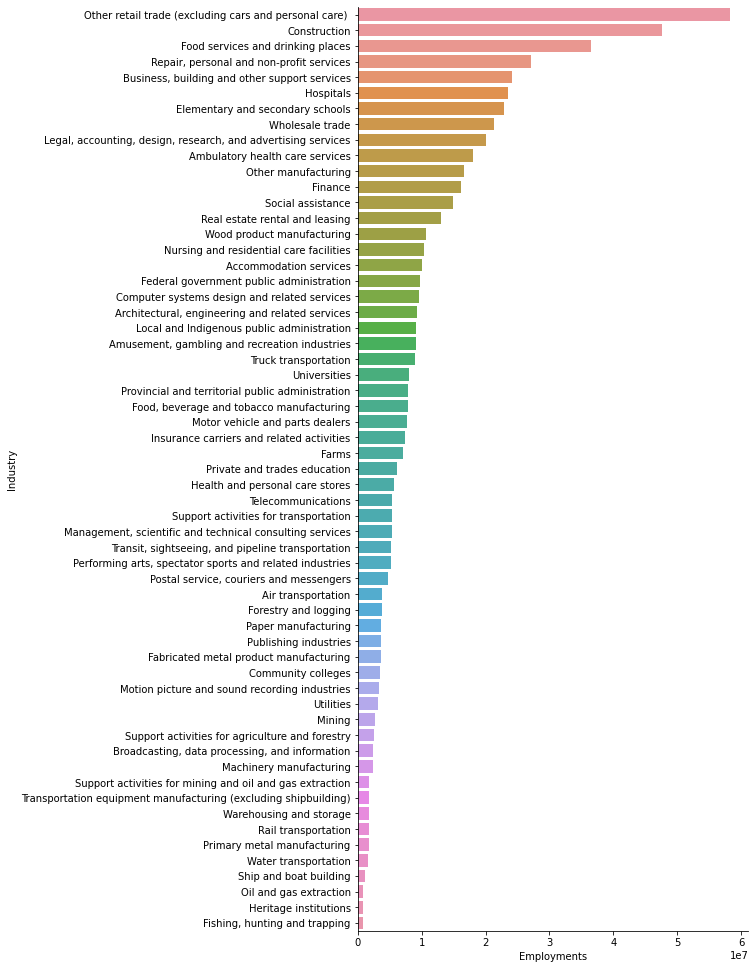

In [ ]:
total_counts = data.groupby('industry_name')['employment'].sum().sort_values(ascending=False)
total_df = pd.DataFrame({'Industry':total_counts.index, 'Employments':total_counts.values})
plt.figure(figsize=(7,17))
sns.barplot(x='Employments', y='Industry', data = total_df);


# Time Series Analysis

In [ ]:
data = pd.DataFrame(data.reset_index().groupby(['date', 'industry_name'], as_index=False)['employment'].sum())

In [ ]:
data.head()

,date,industry_name,employment
0,1997-01-01,Accommodation services,24250
1,1997-01-01,Air transportation,17250
2,1997-01-01,Ambulatory health care services,40250
3,1997-01-01,"Amusement, gambling and recreation industries",19750
4,1997-01-01,"Architectural, engineering and related services",27000


In [ ]:
data = data.pivot('date', 'industry_name', 'employment')
data['total'] = data.sum(axis=1)
data = data.iloc[:-3]
data.index.freq = 'MS'

In [ ]:
data.index

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', name='date', length=273, freq='MS')

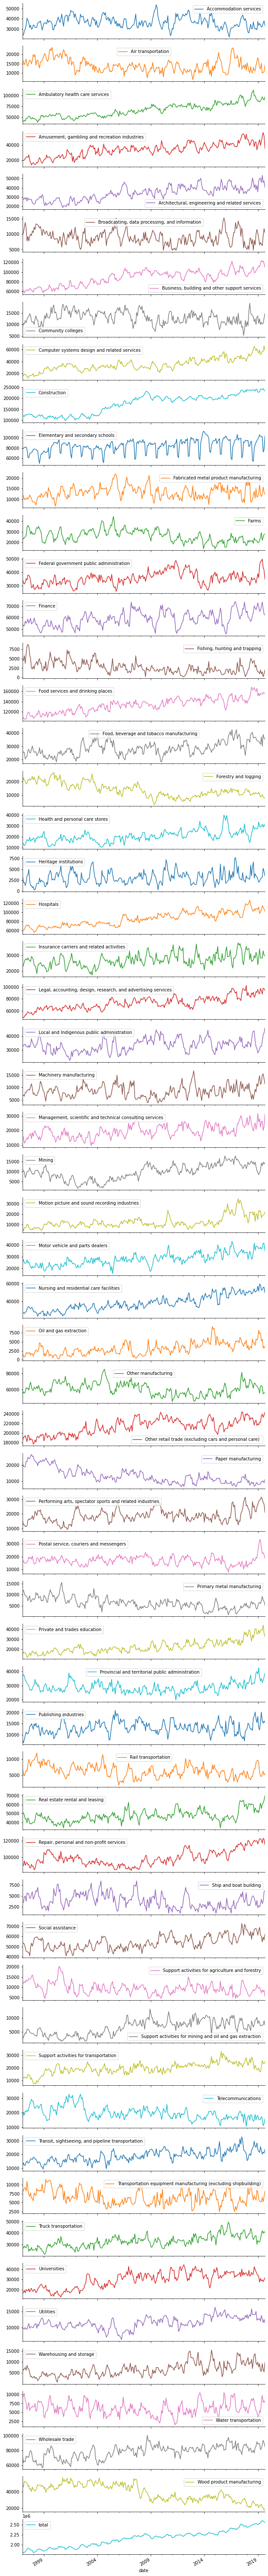

In [ ]:
# plt.figure(dpi=200)
data.plot(subplots=True, figsize=(10, 120));

## How employment in Construction evolved over time and how this compares to the total employment across all industries?

For complete analysis, we have to analyse 
- trend - upward, horizontal/stationary, downward
- seasonality - repeating trends  
- cyclical - trends with no set repetition  

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 13.7 MB/s 
     |████████████████████████████████| 9.8 MB 55.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests 
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pmd

In [ ]:
# define ADFuller test for better explanation
def adf_test(series, title = ''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF test statistics', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical values ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("""
        >> Strong evidence against null hypothesis.  
        >> Reject the null hypothesis. 
        >> Data has no unit root and is stationary
        """)
    else:
        print("""
        >> Weak evidence against the null hypothesis. 
        >> Fail to reject the null hypothesis. 
        >> Data has a unit root and is non-stationary
        """)

## Analysis for construction

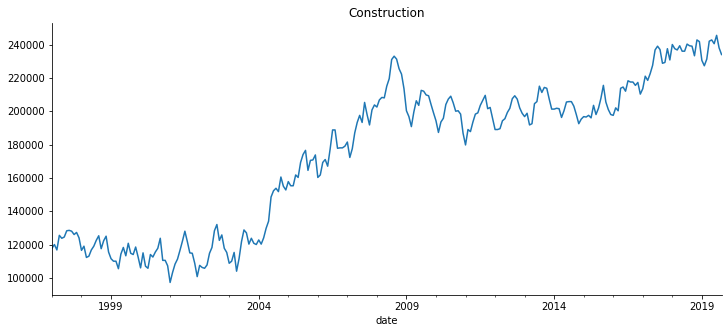

In [ ]:
data['Construction'].plot(figsize=(12,5), title='Construction')

For the above picture, we can clearly see the upward trend and seasonality. We can test the stationary (constant mean and constant variance, i.e no trend) with Augmented Dickey-Fuller test. 

In [ ]:
adf_test(data['total'])

ADF test statistics        0.273342
p-value                    0.976088
# lags used               12.000000
# observations           260.000000
critical values (1%)      -3.455754
critical values (5%)      -2.872721
critical values (10%)     -2.572728

        >> Weak evidence against the null hypothesis. 
        >> Fail to reject the null hypothesis. 
        >> Data has a unit root and is non-stationary
        


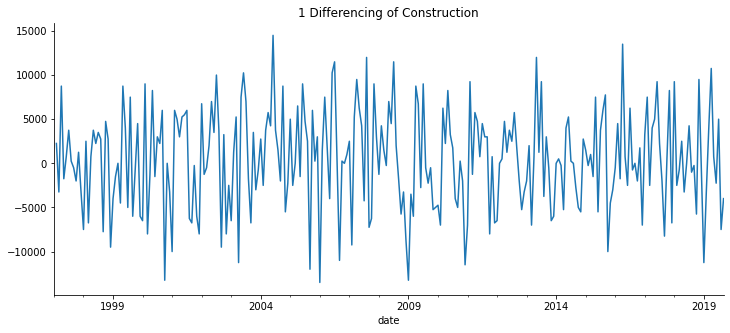

In [ ]:
data['Construction'].diff().plot(figsize=(12,5), title='1 Differencing of Construction')

In [ ]:
adf_test(data['total'].diff())

ADF test statistics       -4.279164
p-value                    0.000483
# lags used               11.000000
# observations           260.000000
critical values (1%)      -3.455754
critical values (5%)      -2.872721
critical values (10%)     -2.572728

        >> Strong evidence against null hypothesis.  
        >> Reject the null hypothesis. 
        >> Data has no unit root and is stationary
        


It means when constructing model, the differencing term (d) should be 1. 

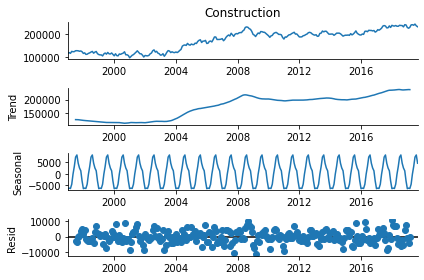

In [ ]:
seasonal = seasonal_decompose(data['Construction'])
seasonal.plot();

We can see the upward trend and annual seasonality for construction. 

### Comparing Total Employment and Construction

As the original data scales do not match and I will be using differencing scales. 

In [ ]:
scaled_total = data['total']/data['total'][0]
scaled_construction = data['Construction']/data['Construction'][0]

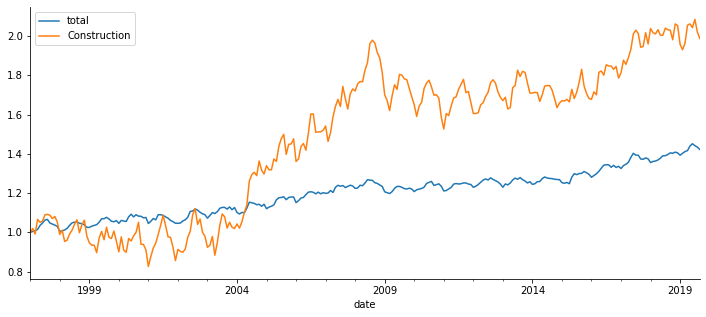

In [ ]:
# plt.figure(dpi=200)
scaled_total.plot(legend=True, figsize=(12,5),)
scaled_construction.plot(legend=True);

After scaling, compared to total industries, the construction industry evolved abruptly started since 2004. There may be an association between total employment and construction but it is difficult to tell there is association between total employment and construction by looking at the graph and so, I will use Granger Causality test to determine. 

### Granger Causality Test  

- if one time series is useful in forecasting another
- used to see if there is an indication of causality, but there could always be some outside factor unaccounted for

In [ ]:
grangercausalitytests(pd.concat([scaled_total, scaled_construction], axis=1), maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1715  , p=0.6791  , df_denom=269, df_num=1
ssr based chi2 test:   chi2=0.1734  , p=0.6771  , df=1
likelihood ratio test: chi2=0.1734  , p=0.6771  , df=1
parameter F test:         F=0.1715  , p=0.6791  , df_denom=269, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7639  , p=0.0244  , df_denom=266, df_num=2
ssr based chi2 test:   chi2=7.6692  , p=0.0216  , df=2
likelihood ratio test: chi2=7.5627  , p=0.0228  , df=2
parameter F test:         F=3.7639  , p=0.0244  , df_denom=266, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6911  , p=0.0467  , df_denom=263, df_num=3
ssr based chi2 test:   chi2=8.2882  , p=0.0404  , df=3
likelihood ratio test: chi2=8.1636  , p=0.0427  , df=3
parameter F test:         F=2.6911  , p=0.0467  , df_denom=263, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0572  , p=0.0868  

{1: ({'lrtest': (0.17336608572122714, 0.6771374245916899, 1),
   'params_ftest': (0.17150861164675918, 0.6791045424472555, 269.0, 1.0),
   'ssr_chi2test': (0.17342134709297358, 0.6770888775149655, 1),
   'ssr_ftest': (0.1715086116470952, 0.6791045424469386, 269.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (7.562693436618247, 0.022791976375589294, 2),
   'params_ftest': (3.7638541286150544, 0.02443887507683075, 266.0, 2.0),
   'ssr_chi2test': (7.669206532741953, 0.02160991014780283, 2),
   'ssr_ftest': (3.763854128615055, 0.02443887507683075, 266.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (8.163572525411382, 0.04274939180198536, 3),
   'params_ftest': (2.69112005618511, 0.04669907993550864, 263.0, 3.0),
   'ssr_chi2test': (8.288240477223688, 0.04041552509554141, 3),
   'ssr_ftest': (2.691120056184975, 0.04669907993551605, 263.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

We can see p-value of less than 0.05 starting from lag 2 and above except 4,5 and so, there is a relationship between total employment and it means if there is an increasing employment in construction, in next 2 months or above, there will be increasing total employment. But keep in mind, there is always some external factors unaccounted for.  

### Autocorrelation and Partial Autocorrelation plots

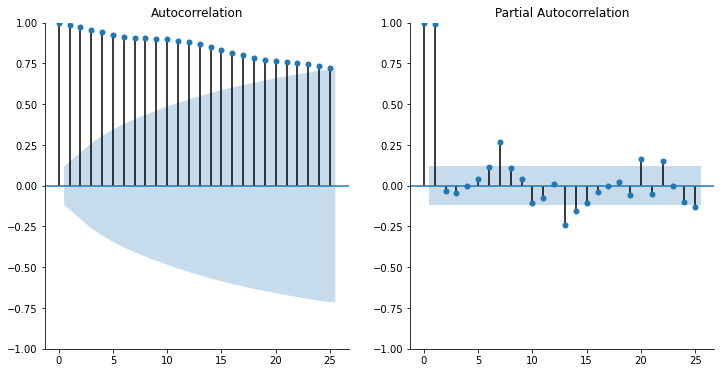

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
plot_acf(data['Construction'], ax=axes[0]);
plot_pacf(data['Construction'], ax=axes[1]);

Theoratically, if autocorrelation plot show positive autocorrelation at first lag, then it suggests to use AR terms in relation to the lag. If autocorrelation plot shows negative autocorrelation at first lag, it suggests to use MA terms. But it is difficult to decide whether to use AR, MA, ARIMA or SARIMA by looking at autocorrelation and partical autocorrelation plots as I am a beginner. So, here, I am searching the best model by grid search by using pmdarima library. 

### Train-Test-Split

In [ ]:
train = data[['Construction']].iloc[:-12]
test = data[['Construction']].iloc[-12:]

In [ ]:
model = pmd.auto_arima(train, seasonal=True, m=12, 
                    start_p=0, start_q=0, max_p=12, max_q=12, d=1, D=1,
                       start_P=0, start_Q=0, max_P=12, max_Q=12, trace=True, stepwise=True)                                                                                                                                                  

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5059.977, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5033.414, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5018.998, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5055.272, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5002.930, Time=1.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.41 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=5003.705, Time=2.40 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=5005.308, Time=4.66 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5000.250, Time=0.79 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5019.925, Time=0.22 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=i

The best model for total is p=0, d=1, q=0, P=0, D=1, Q=2 and Seasonal=12 with AIC score=5011.

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  261
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -2497.125
Date:                                 Thu, 13 Jan 2022   AIC                           5000.250
Time:                                         18:17:27   BIC                           5010.790
Sample:                                              0   HQIC                          5004.493
                                                 - 261                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5107      0.043    -11.971      0.000      -0.594      -0.427
ma.S.L24      -0.2509      0.031     -8.097      0.000      -0.312      -0.190
sigma2      3.412e+07   2.84e-10    1.2e+17      0.000    3.41e+07    3.41e+07
===================================================================================
Ljung-Box (L1) (Q):                  10.13   Jarque-Bera (JB):                19.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.04e+31. Standard errors may be unstable.
"""

### Model evaluation

In [ ]:
forecast = model.predict(test.shape[0], dynamic=False, typ='levels')
forecast = pd.Series(forecast, index=test.index).rename('Forecast')

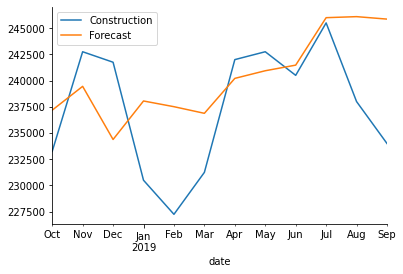

In [ ]:
data['Construction'].iloc[-12:].plot(legend=True)
forecast.plot(legend=True)

In [ ]:
print(f"RMSE                           : {rmse(data['Construction'].iloc[-12:], forecast)}")
print(f"Average value of original data : {np.mean(data['Construction'].iloc[-12:])}")

RMSE                           : 6380.9136072016645
Average value of original data : 237458.33333333334


The model is not bad with error nearly 6300 employments compared to average value of 237458. 

### Forecasting the Future

Retrain the model with all time series and the model is the same. 

In [ ]:
model = pmd.auto_arima(data['Construction'], seasonal=True, m=12, 
                    start_p=1, start_q=1, max_p=12, max_q=12, d=1, D=1,
                       start_P=0, start_Q=0, max_P=12, max_Q=12, trace=True, stepwise=True)   

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5305.299, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5308.406, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5280.970, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5265.084, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5303.509, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5247.958, Time=1.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5248.001, Time=3.26 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=5249.034, Time=2.69 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=inf, Time=6.03 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5244.698, Time=0.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5265.577, Time=0.22 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=3.78 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=5245.801, Time=1.82 sec
 ARIMA(0,1,0)(1,1,1)[12]          

I will forecast until December 2021. According to data, it is the future. 

In [ ]:
forecast_date_index = pd.date_range('2019-10-01', periods=27, freq='MS')
total_forecast_months = 27

In [ ]:
forecast = model.predict(total_forecast_months, typ='level')
forecast = pd.Series(forecast, index=forecast_date_index).rename('Forecast Construction')

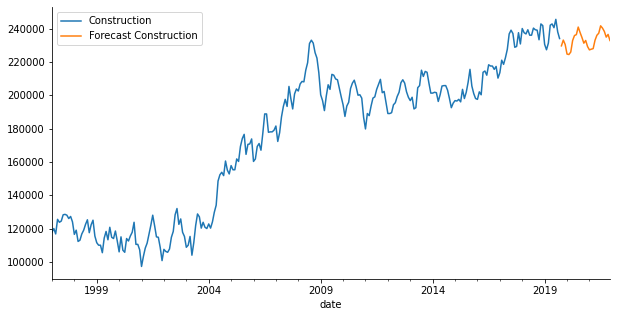

In [ ]:
data['Construction'].rename('Construction').plot(legend=True, figsize=(10,5))
forecast.plot(legend=True);

Actually, these steps should be done for time series analysis but there are next 59 variables left to do. So, I will left the analysis steps and will only forecast. 

## Forecasting all Employments

In [ ]:
def forecasting(series):
    model = pmd.auto_arima(series, seasonal=True, m=12, 
                    start_p=1, start_q=1, max_p=5, max_q=5, d=1, D=1,
                       start_P=0, start_Q=0, max_P=5, max_Q=5, trace=True, stepwise=True)  
    forecast_date_index = pd.date_range('2019-10-01', periods=27, freq='MS')
    total_forecast_months = 27
    forecast = model.predict(total_forecast_months, typ='level')
    forecast = pd.Series(forecast, index=forecast_date_index)
    return forecast, model.get_params()

In [ ]:
# this block will take a lot of time to run (3 hours in Colab)
# col_names = data.columns
# predicted_df = pd.DataFrame()
# params = dict()
# done = 0
# for col in col_names:
#     predicted_df[col], params[col] = forecasting(data[col])
#     done += 1
#     print(done)
# predicted_df.to_csv('predicted_df.csv')

In [ ]:
predicted_df = pd.read_csv('predicted_df.csv')
predicted_df.iloc[:,0] = pd.to_datetime(predicted_df.iloc[:,0])
predicted_df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
predicted_df.set_index('date', inplace=True)

In [ ]:
# pd.DataFrame(params).to_csv('params.csv')

## Find the slope of the trend line

In [ ]:
from datetime import datetime
from scipy import stats
date_ordinal = data.index.map(datetime.toordinal)
slopes = []
for col in data.columns:
    slope, _, _, _, _ = stats.linregress(date_ordinal, data[col])
    slopes.append(slope)

In [ ]:
slope_df = pd.DataFrame({'Industry':data.columns, 'Slopes':slopes}).sort_values('Slopes', ascending=False).iloc[1:,:]

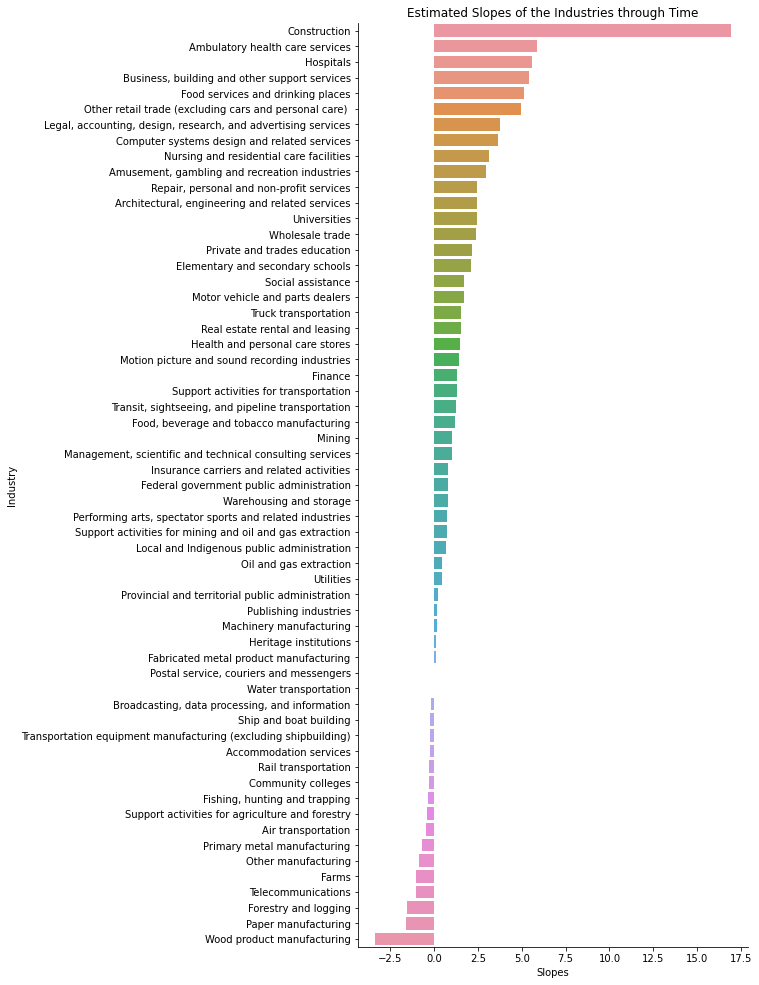

In [ ]:
plt.figure(figsize=(7, 17))
sns.barplot(y='Industry', x='Slopes', data = slope_df)
plt.title('Estimated Slopes of the Industries through Time');